# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). Right now the autoencoder architecture is copy/pasted from [this](https://blog.keras.io/building-autoencoders-in-keras.html) Keras tutorial.

ToDo:
- Implement U-Net
- Find colored dataset to train on

In [32]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np

In [33]:
image_size  = 28
autoencoder_depth = 10
dropout = 0.1
channels = 1

In [34]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], image_size, image_size, channels))
x_test = np.reshape(x_test, (x_test.shape[0], image_size, image_size, channels))
x_train.shape

(60000, 28, 28, 1)

## Autoencoder

In [44]:
def EncoderBlock():
    def apply(x):
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
        return encoded
        
    return apply

def DecoderBlock():
    def apply(x):
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3, 3), activation='relu')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        return decoded
    
    return apply
    
def create_autoencoder():
    input_image = layers.Input(shape=(image_size, image_size, channels))
    encoded = EncoderBlock()(input_image)
    # At this point the representation is (4, 4, 8) i.e. 128-dimensional.
    decoded = DecoderBlock()(encoded)
    
    autoencoder = keras.Model(input_image, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder = keras.Model(input_image, encoded)
    
    return autoencoder, encoder

# Decoder should only be created after autoencoder has been trained.
def create_decoder(base_model):
    latent_input = layers.Input(shape=(4, 4, 8))
    decoded = DecoderBlock()(latent_input)
    decoder = keras.Model(latent_input, decoded)
    
    for i in range(7):
        decoder.layers[i+1].set_weights(base_model.layers[i+7].get_weights())
        
    return decoder

In [47]:
autoencoder, encoder = create_autoencoder()
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test))
decoder = create_decoder(autoencoder)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.2227 - val_loss: 0.1487
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1397 - val_loss: 0.1319
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1270 - val_loss: 0.1210
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1193 - val_loss: 0.1152
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1144 - val_loss: 0.1114
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.1112 - val_loss: 0.1091
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1087 - val_loss: 0.1067
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1068 - val_loss: 0.1051
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1052 - val_loss: 0.1033
Epoch 10/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1038 - val_loss: 0.1023

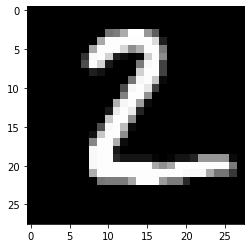

In [56]:
plt.imshow(x_test[1].reshape(28, 28), cmap='gray')

313/313 [==============================] - 0s 1ms/step


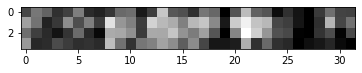

In [54]:
encoded_images = encoder.predict(x_test)
plt.imshow(encoded_images[0].reshape((4, 4 * 8)), cmap='gray')

313/313 [==============================] - 0s 814us/step


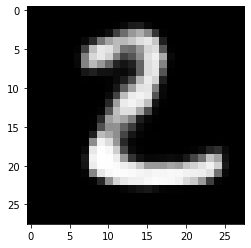

In [53]:
decoded_images2 = decoder.predict(encoded_images)
plt.imshow(decoded_images2[1].reshape(28, 28), cmap='gray')

## Denoising U-Net